# Quantifying poly(A) sites as junction counts relative to 5' TE splice junction


The throw it out there idea is that if this is reliable (i.e. just considering counts across poly(A) sites (accounting for minimum overhang)

In [47]:
import os
import pandas as pd
import pysam
from plotnine import *
os.getcwd()

paqr_rel_usages_path = "../../data/relative_usages.filtered.tsv"
rel_usages_header_path = "../../data/relative_usages.header.out"
m323k_wt_1_bam_path = "/home/sam/cluster/TDP43_RNA/TDP_F210I_M323K/M323K/New_adult_brain/processed/M323K_WT_1/M323K_WT_1_unique_rg_fixed.bam"
m323k_hom_1_bam_path = "/home/sam/cluster/TDP43_RNA/TDP_F210I_M323K/M323K/New_adult_brain/processed/M323K_HOM_1/M323K_HOM_1_unique_rg_fixed.bam"

rel_usages = pd.read_csv(paqr_rel_usages_path,sep="\t")

with open(rel_usages_header_path) as inpt:
    
    sample_names = [line.rstrip() for line in inpt]


#print(rel_usages)
#print(sample_names)

#First 10 columns are the same in relative usages df
colnames_rel_usages = ["chr",
 "cluster_start",
 "cluster_end",
 "site_id",
 "score",
 "strand",
 "n_along_exon",
 "total_sites_on_exon", 
 "paqr_exon_id", 
 "gene_id" # this is technically transcript_id but for now I'll leave it...
]

#Rest of columns are samples names in order found in relative usages output df
colnames_rel_usages.extend(sample_names)

print(colnames_rel_usages)


#Because samples are paired according to config - can appear multiple times in df...
sample_names = set(sample_names)
print(sample_names)

rel_usages.columns = colnames_rel_usages
print(rel_usages)

['chr', 'cluster_start', 'cluster_end', 'site_id', 'score', 'strand', 'n_along_exon', 'total_sites_on_exon', 'paqr_exon_id', 'gene_id', 'M323K_WT_1', 'M323K_HOM_1', 'M323K_WT_2', 'M323K_HOM_2', 'M323K_WT_3', 'M323K_HOM_3', 'M323K_WT_4', 'M323K_HOM_4', 'M323K_WT_1', 'M323K_HOM_5']
{'M323K_HOM_4', 'M323K_WT_1', 'M323K_HOM_5', 'M323K_HOM_1', 'M323K_HOM_3', 'M323K_WT_2', 'M323K_WT_4', 'M323K_HOM_2', 'M323K_WT_3'}
        chr  cluster_start  cluster_end               site_id  score strand  \
0     chr16       20544628     20544662   chr16:+:20544651:TE      4      +   
1      chrX      133931787    133931831   chrX:+:133931813:TE      7      +   
2      chrX      133932295    133932296   chrX:+:133932296:TE      1      +   
3     chr17       75390823     75390843   chr17:+:75390843:TE      1      +   
4     chr17       75391754     75391779   chr17:+:75391769:TE      8      +   
...     ...            ...          ...                   ...    ...    ...   
3498   chr1      171388592    1713

In [48]:

#grouped = rel_usages.groupby("gene_id")
#print(grouped)

#for a, b in grouped:
#    print(a)
#    print(b["site_id"].to_list())

    
    
def polyASite_id_to_coordinate_tuple(paqr_df, site_id_colname = "site_id", group_col = "gene_id"):
    '''
    Nested dict of {<group_col_key>: {site_id: (chr, start, end)}}}
    Assume coord is 1 based, output will be 0 based, 1/2 open
    '''
    
    df_grouped = paqr_df.groupby(group_col)
    
    out_dict = {}
    
    for group_name, group in df_grouped:
        
        site_ids = group[site_id_colname].to_list()
        nested_dict = {}
        
        for site in site_ids:
            #'chr11:+:55110898:TE'
            ID = site.split(':')
            seq_tuple = (ID[0], int(ID[2]), int(ID[2]) + 1)
            
            nested_dict[site] = seq_tuple 
            
        out_dict[group_name] = nested_dict
        
        
    return out_dict


polya_jnc_coords = polyASite_id_to_coordinate_tuple(rel_usages)
#print(polya_jnc_coords)


### For testing, let's just look at a few transcripts
small_polya_jnc_coords = {key: polya_jnc_coords[key] for key in list(polya_jnc_coords.keys())[:5]}
#print(small_polya_jnc_coords)

Now I've got my PAQR inferred/ PolyASite poly(A) sites , I want to try and count the number of reads that span these positions - 'junction reads'

As I will want to quantify these junctions relative to the splice junction at the 5'end of the terminal exon, I have to treat the poly(A) junction alignments as if they were a splice junction (where sequence is disjointly aligned to the genome

STAR (and likely other splice-aware aligners) has a --alignSJDBoverhangMin parameter, which requires that a putative junction read 'overhangs' the junction by at least x nt (x = 3 by default) in orfer for it to be assigned to the junction


Reads aligned to genome at poly(A) sites aren't subject to this parameter, so junction counts would be inflated relative to the 5' splice junction


using pysam, for each read crossing the poly(A) site, check whether start or end of read alignment falls within 3nt of the poly(A) site coordinate

abs(polya_site - alignment_start) > 3 and abs(alignment_end - polya_site) > 3 = valid poly(A) site junction read





In [49]:
#WT 1

wt_1 = pysam.AlignmentFile(m323k_wt_1_bam_path, "rb")


jnc_counts_dict = {}

for transcript, polya_dict in small_polya_jnc_coords.items():
    # store junction read counts for every poly(A) site in transcript
    tr_polya_dict = {}
    #print(polya_dict)
    
    for polya_site, coords_tuple in polya_dict.items():
        
        #Reads overlapping poly(A) site
        site_jnc_read_count = 0
        
        for read_entry in wt_1.fetch(coords_tuple[0], coords_tuple[1], coords_tuple[2]):
            
            #0-based leftmost reference coordinate of the aligned sequence
            align_start = read_entry.reference_start
            
            # Aligned reference position of the read on the reference genome.
            # Reference_end points to one past the last aligned residue. Returns None if not available (read is unmapped or no cigar alignment present).

            align_end = read_entry.reference_end
            
            #print(read_entry.query_name)
            #print("align_start: {0}, align_end: {1}".format(str(align_start), str(align_end)))
            
            #polyA site - align_start & align_end - polya_site
            if abs(coords_tuple[1] - align_start) > 3 and abs(align_end - coords_tuple[1]) > 3:
                site_jnc_read_count += 1
                
            else:
                pass
        
        #Now have checked every read overlapping poly(A) site
        tr_polya_dict[polya_site] = site_jnc_read_count
        
    
    #Now have counted junction reads for each poly(A) site in transcript
    jnc_counts_dict[transcript] = tr_polya_dict
    
    

#print(jnc_counts_dict)


def is_polya_junction_read(read_entry,polya_start, sj_overhang):
    '''
    
    '''
    
    #0-based leftmost reference coordinate of the aligned sequence
    align_start = read_entry.reference_start
           
    # Aligned reference position of the read on the reference genome.
    # Reference_end points to one past the last aligned residue. Returns None if not available (read is unmapped or no cigar alignment present).

    align_end = read_entry.reference_end
    
    if abs(polya_start - align_start) > sj_overhang and abs(align_end - polya_start) > sj_overhang:
        return True
    
    else:
        return False
    

    
#Try a more compartmentalised version of count_dict
jnc_counts_dict_2 = {}

for transcript, polya_dict in small_polya_jnc_coords.items():
    
    tr_polya_counts = {polya_site: sum(is_polya_junction_read(read, coords_tuple[1], 3) for read in wt_1.fetch(coords_tuple[0], 
                                                                            coords_tuple[1], 
                                                                            coords_tuple[2]))
                       for polya_site, coords_tuple in polya_dict.items()}

    jnc_counts_dict_2[transcript] = tr_polya_counts

    
#print(jnc_counts_dict_2)

wt_1.close()

def get_polya_junction_counts_dict(bam_path, jnc_coords_dict, sj_overhang):
    '''
    '''

    bam = pysam.AlignmentFile(bam_path, "rb")
    
    #final output dict of {tr: {site_id: jnc_counts}}
    counts_dict = {}
    
    for transcript, polya_coords_dict in jnc_coords_dict.items():
        
        polya_coords_counts = {polya_site: sum(is_polya_junction_read(read,
                                                                      coords_tuple[1],
                                                                      sj_overhang) 
                                               
                                               for read in bam.fetch(coords_tuple[0], 
                                                                     coords_tuple[1], 
                                                                     coords_tuple[2])
                                              )
                               for polya_site, coords_tuple in polya_coords_dict.items()}
        
        counts_dict[transcript] = polya_coords_counts
        
    
    bam.close()
    
    return counts_dict

wt_1_polya_jnc_counts = get_polya_junction_counts_dict(m323k_wt_1_bam_path, small_polya_jnc_coords, 3)
hom_1_polya_jnc_counts = get_polya_junction_counts_dict(m323k_hom_1_bam_path, small_polya_jnc_coords, 3)

#print(len(wt_1_polya_jnc_counts))
#print(len(hom_1_polya_jnc_counts))

print(wt_1_polya_jnc_counts)
print(hom_1_polya_jnc_counts)

{'ENSMUST00000000608': {'chr11:+:55110898:TE': 3, 'chr11:+:55113026:TE': 1}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': 212, 'chr2:+:181515774:TE': 102, 'chr2:+:181516756:TE': 26}, 'ENSMUST00000000896': {'chr2:-:154587124:TE': 16, 'chr2:-:154585759:TE': 0}, 'ENSMUST00000000985': {'chr14:+:54368610:TE': 64, 'chr14:+:54369669:TE': 4}, 'ENSMUST00000001079': {'chr3:-:129983184:TE': 49, 'chr3:-:129982765:TE': 1}}
{'ENSMUST00000000608': {'chr11:+:55110898:TE': 3, 'chr11:+:55113026:TE': 1}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': 212, 'chr2:+:181515774:TE': 102, 'chr2:+:181516756:TE': 26}, 'ENSMUST00000000896': {'chr2:-:154587124:TE': 16, 'chr2:-:154585759:TE': 0}, 'ENSMUST00000000985': {'chr14:+:54368610:TE': 64, 'chr14:+:54369669:TE': 4}, 'ENSMUST00000001079': {'chr3:-:129983184:TE': 49, 'chr3:-:129982765:TE': 1}}
5
5
{'ENSMUST00000000608': {'chr11:+:55110898:TE': 3, 'chr11:+:55113026:TE': 1}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': 212, 'chr2:+:181515774:TE': 102, 'chr2:+:18

**Now I need counts for junction reads at 5' end of terminal exon**

The coordinates are provided in the paqr output table, - suggest pulling from the exon_id string

Coordinates are bed-like i.e. 0-based, 1/2 open - start is included, end is not
I want the splice junction coordinates to follow this
if + strand then start of exon = start coordinate
if - strand then start of exon = end coordinate (-1)



In [69]:
#Want dictionary of {transcript_id: (chr, start, end, )}

#print(small_polya_jnc_coords)
#print(rel_usages)

def paqr_out_to_sj_coord_tuple(paqr_df, 
                               group_col = "gene_id",
                               exon_colname = "paqr_exon_id",
                               chr_colname = "chr", 
                               strand_colname = "strand"):
    '''
    Get dict of {transcript_id: (chr, start, end)} where coords are for 5' splice junction of terminal exon
    '''
    
    out_dict = {}
    
    df_grouped = paqr_df.groupby(group_col)
    
    for group_name, group in df_grouped:
        
        
        # Every id should have same strand, chromosome and terminal exon string, so only need 1 row
        # List selection ensures return a dataframe
        group = group.iloc[[0]]
        
        #exon id like ENSMUST00000007216:12:12:20543310:20544909
        exon_split = group[exon_colname].to_string(index = False).split(':')
        
        if (group[strand_colname] == "+").bool():
            #5 coord = start of te (& start coord = actual start)
                        
            coord_tuple = tuple([group[chr_colname].to_string(index = False).lstrip(' '),
                                int(exon_split[-2]),
                                int(exon_split[-2]) + 1
                                ])
            
        elif (group[strand_colname] == "-").bool():
            #5 of exon = end coord in string (half-open, so actual start coord = end -1)
            
            coord_tuple = tuple([group[chr_colname].to_string(index = False).lstrip(' '),
                                int(exon_split[-1]) -1,
                                int(exon_split[-1])
                                ])
            
        out_dict[group_name] = coord_tuple
    
    return out_dict


splice_jnc_coords = paqr_out_to_sj_coord_tuple(rel_usages)
#print(splice_jnc_coords)


#Now lets make a small_splice_jnc_coords with same sjs as in small_polya_jnc_coords

small_splice_jnc_coords = {key: val for key, val in splice_jnc_coords.items() 
                           if key in small_polya_jnc_coords.keys()}

print(small_splice_jnc_coords)
print(small_polya_jnc_coords)

{'ENSMUST00000000608': ('chr11', 55109377, 55109378), 'ENSMUST00000000844': ('chr2', 181515079, 181515080), 'ENSMUST00000000896': ('chr2', 154588091, 154588092), 'ENSMUST00000000985': ('chr14', 54368317, 54368318), 'ENSMUST00000001079': ('chr3', 129984005, 129984006)}
{'ENSMUST00000000608': {'chr11:+:55110898:TE': ('chr11', 55110898, 55110899), 'chr11:+:55113026:TE': ('chr11', 55113026, 55113027)}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': ('chr2', 181515384, 181515385), 'chr2:+:181515774:TE': ('chr2', 181515774, 181515775), 'chr2:+:181516756:TE': ('chr2', 181516756, 181516757)}, 'ENSMUST00000000896': {'chr2:-:154587124:TE': ('chr2', 154587124, 154587125), 'chr2:-:154585759:TE': ('chr2', 154585759, 154585760)}, 'ENSMUST00000000985': {'chr14:+:54368610:TE': ('chr14', 54368610, 54368611), 'chr14:+:54369669:TE': ('chr14', 54369669, 54369670)}, 'ENSMUST00000001079': {'chr3:-:129983184:TE': ('chr3', 129983184, 129983185), 'chr3:-:129982765:TE': ('chr3', 129982765, 129982766)}}


In [75]:
## Ok now need to search bam for reads overlapping splice jnc coord,
## count number of aligned reads crossing splice junction
## 

def get_splice_junction_counts_dict_depr(bam_path, jnc_coords_dict):
    '''
    output dict of {tr: count}
    '''

    bam = pysam.AlignmentFile(bam_path, "rb")
    
    #final output dict of {tr: {site_id: jnc_counts}}
    counts_dict = {transcript: (sum(1 for read in bam.fetch(coords_tuple[0], 
                                              coords_tuple[1], 
                                              coords_tuple[2])))
                  for transcript, coords_tuple in jnc_coords_dict.items()}
    
    bam.close()
    
    return counts_dict

wt_1_splice_jnc_counts_depr = get_splice_junction_counts_dict_depr(m323k_wt_1_bam_path, small_splice_jnc_coords)
hom_1_splice_jnc_counts_depr = get_splice_junction_counts_dict_depr(m323k_hom_1_bam_path, small_splice_jnc_coords)

print(wt_1_splice_jnc_counts_depr)
print(wt_1_polya_jnc_counts)

print(hom_1_splice_jnc_counts_depr)
print(hom_1_polya_jnc_counts)


{'ENSMUST00000000608': 310, 'ENSMUST00000000844': 450, 'ENSMUST00000000896': 30, 'ENSMUST00000000985': 183, 'ENSMUST00000001079': 192}
{'ENSMUST00000000608': {'chr11:+:55110898:TE': 3, 'chr11:+:55113026:TE': 1}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': 212, 'chr2:+:181515774:TE': 102, 'chr2:+:181516756:TE': 26}, 'ENSMUST00000000896': {'chr2:-:154587124:TE': 16, 'chr2:-:154585759:TE': 0}, 'ENSMUST00000000985': {'chr14:+:54368610:TE': 64, 'chr14:+:54369669:TE': 4}, 'ENSMUST00000001079': {'chr3:-:129983184:TE': 49, 'chr3:-:129982765:TE': 1}}
{'ENSMUST00000000608': 475, 'ENSMUST00000000844': 482, 'ENSMUST00000000896': 48, 'ENSMUST00000000985': 244, 'ENSMUST00000001079': 196}
{'ENSMUST00000000608': {'chr11:+:55110898:TE': 2, 'chr11:+:55113026:TE': 0}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': 268, 'chr2:+:181515774:TE': 90, 'chr2:+:181516756:TE': 27}, 'ENSMUST00000000896': {'chr2:-:154587124:TE': 20, 'chr2:-:154585759:TE': 0}, 'ENSMUST00000000985': {'chr14:+:54368610:TE': 66, 'chr1

These counts are way way off... (NB I don't think this is necessarily the case - remember reads overlapping poly(A) sites = support for downstream poly(A) sites - these transcripts could just have really high usage of proximal site. Point still stands though, I need to be much smarter)

I think I'm going to actually have to do some smart filtering to get junction read counts

i.e. for every read in bam.fetch(splice junction), check read is
primary alignment/uniquely aligned

is a split alignment i.e has 'N' in cigar string & this split alignment starts at the splice junction i.e. read skips a bit of reference sequence (intron) then starts at splice junction with contiguous/consective alignment to reference (i.e. exon)

`~~~` - intron

`___ `- exon

`|` - splice junction

`------` - read

I'm interested in reads spanning  the splice junction of 'exon 2' (i.e. the TE)

What i'm really after is the total number of reads supporting inclusion of/crossing this junction
I'm not particularly interested which upstream exon/ splice junction it is spliced to, just that it supports inclusion of the terminal exon junction

If I want to make sure it is a read connecting two exons (but without caring what the other junction is), I can check the cigar string such that the intron (N) is bounded by exact reference matches of at least (3) nt on either side e.g. a string like
**70M84N5M** or for readability **70M 84N 5M** 
would be a valid read because a reference gap of 84N (intron) is separated by a consecutive match to reference (exon) >= 3nt on either side

To be extra sure, I should really check the N & M segments align with reference coordinate/junction I'm interested in...

**to this end, I just want reads that cross the TE splice junction, and contain a 'right hand overhang'. --alignSJDBoverhangMin, of at least x nt (default 3nt) i.e. x nt of the terminal exon** 

Maybe also only want to count spliced alignments, but for now let's not worry about that??


5' exon 1                            exon 2            3'

`____________|~~~~~~~~~~~~~~~~~~|______________`

`xxxxxx-------NNNNNNNNNNNNNNNNNN-------xxxxxxxx` Read supporting splicing-in/inclusion of this TE

`xx-----------NNNNNNNNNNNNNNNNNN--xxxxxxxxxxxxx`

`xxxxxxxxxxxxxxxxxxxxxxxxxxxx----------------xx`


check if right hand overhang is > --alignSJDBoverhangMin (usually 3nt) i.e. aligned portion of read has at least 3nt of terminal exon sequence



In [110]:
test_tr_splice_jnc_tuple = small_splice_jnc_coords.get('ENSMUST00000000985')
#print(test_tr_splice_jnc_tuple)



x = 0


#test_reads_dict = {}
#for read in wt_1.fetch(test_tr_splice_jnc_tuple[0],
#                    test_tr_splice_jnc_tuple[1],
#                    test_tr_splice_jnc_tuple[2]):
    
#    while x < 10:
#        if test_tr_splice_jnc_tuple in test_reads_dict.keys():
#            #add AlignedSegment object for read to end of list for given splice jnc
#            test_reads_dict[test_tr_splice_jnc_tuple].append(read.to_dict())
#        
#        else:
#            test_reads_dict[test_tr_splice_jnc_tuple] = [read.to_dict()]
#            
#        x += 1
#    else:
#        break
    
#print(x)
#print(test_reads_dict)

'''
cigartuples

    the cigar alignment. The alignment is returned as a list of tuples of (operation, length).

    If the alignment is not present, None is returned.

    The operations are:
    M 	BAM_CMATCH 	0
    I 	BAM_CINS 	1
    D 	BAM_CDEL 	2
    N 	BAM_CREF_SKIP 	3
    S 	BAM_CSOFT_CLIP 	4
    H 	BAM_CHARD_CLIP 	5
    P 	BAM_CPAD 	6
    = 	BAM_CEQUAL 	7
    X 	BAM_CDIFF 	8
    B 	BAM_CBACK 	9


I neeed to check for M followed by 

'''

#spliced_read_test_count_dict = {}


def get_splice_junction_counts_dict(bam_path, jnc_coords_dict, sj_overhang):
    '''
    Return dict of {tr: (sj_coord_tuple, jnc_count)}
    '''
    
    bam = pysam.AlignmentFile(bam_path, "rb")
    
    out_dict = {}
    
    # Want to get indexes of Ms in a M | N | M sequence from cigartuples
    # (can then slice parsed_cigar to check whether Ms are long enough)
    # M | N | M = [0, 3, 0] (in cigartuples looking to match to first element in each tuple)
    
    seq_to_check = [0, 3, 0]
    
    for transcript, coords_tuple in jnc_coords_dict.items():
        
        jnc_count = 0
        for read in bam.fetch(coords_tuple[0],
                              coords_tuple[1],
                              coords_tuple[2]):
            
            # check for match (M) | reference skip/intron (N) | match (M)
            parsed_cigar = read.cigartuples
            
            # Want to get indexes of Ms in a M | N | M sequence from cigartuples
            # If want to check intron/M start for consistency with SJ, remove the -1 
            cigar_check = [(i, i + len(seq_to_check) - 1) for i in range(len(parsed_cigar))
                       if [tup[0] for tup in parsed_cigar[i:i + len(seq_to_check)]] == seq_to_check]
            
            
            if len(cigar_check) > 0:
                
                #Do Ms in M | N | M sequence have minimum sj_overhang for both Ms?
                cigar_valid = [True for idx_start, idx_end in cigar_check
                               if parsed_cigar[idx_start][1] >= sj_overhang 
                               and parsed_cigar[idx_end][1] >= sj_overhang]
                
                if len(cigar_valid) > 0:
                    # Read has valid alignment spanning junction
                    jnc_count += 1
                
                else:
                    #Read spans a exon-exon junction 
                    #but doesn't have enough exonic alignment either side to count read
                    continue
            
            else:
                
                continue
        
        #Now have checked every read with alignment at sj position
        out_dict[transcript] = tuple([coords_tuple, jnc_count])
        
    bam.close()
    
    return out_dict



wt_1_splice_jnc_counts_small = get_splice_junction_counts_dict(m323k_wt_1_bam_path, small_splice_jnc_coords, 3)
hom_1_splice_jnc_counts_small = get_splice_junction_counts_dict(m323k_hom_1_bam_path, small_splice_jnc_coords, 3)

print(wt_1_splice_jnc_counts_small)
print(hom_1_splice_jnc_counts_small)

'''
wt_1 = pysam.AlignmentFile(m323k_wt_1_bam_path, "rb")
jnc_count = 0
for read in wt_1.fetch(test_tr_splice_jnc_tuple[0],
                    test_tr_splice_jnc_tuple[1],
                    test_tr_splice_jnc_tuple[2]):
    
    # check for match (M) | reference skip/intron (N) | match (M)
    parsed_cigar = read.cigartuples
    #print(parsed_cigar)
    #print(len(parsed_cigar))
        
    # Want to get indexes of Ms in a M | N | M sequence fro cigartuples
    # (can then slice parsed_cigar to check whether Ms are long enough)
    # M | N | M = [0, 3, 0] (in cigartuples looking to match to first element in each tuple)
    seq_to_check = [0, 3, 0]
        
    #print(parsed_cigar[0:0+len(seq_to_check)])
        
        
    cigar_check = [(i, i + len(seq_to_check) - 1) for i in range(len(parsed_cigar))
                       if [tup[0] for tup in parsed_cigar[i:i + len(seq_to_check)]] == seq_to_check]
        
    #print(len(cigar_check))
        
    if len(cigar_check) > 0:
        # Has a putative exon - exon alignment
        # Now check if length of matched sequences is sufficient
        
        for idx_start, idx_end in cigar_check:
                
            # Now check each string in matching sequence
            if parsed_cigar[idx_start][1] > 3 and parsed_cigar[idx_end][1] > 3:
                print("read has minimum overhang & is valid junction read")
                jnc_count += 1

            else:
                print("read does not have minimum exon-exon overhang")
                        
                    
    else:
        print("Read does not have a putative exon-exon junction alignment")            
       
        
print(jnc_count)    

print(test_tr_splice_jnc_tuple)
#for col in wt_1.pileup(test_tr_splice_jnc_tuple[0],
#                      test_tr_splice_jnc_tuple[1],
#                      test_tr_splice_jnc_tuple[2]):
#    print("coverage at position {0} : {1}".format(col.pos, col.n))
    
count = 0
for col in wt_1.fetch('chr2', 154588091, 154588092):
    count +=1

print(count)
wt_1.close()
'''

{'ENSMUST00000000608': (('chr11', 55109377, 55109378), 305), 'ENSMUST00000000844': (('chr2', 181515079, 181515080), 432), 'ENSMUST00000000896': (('chr2', 154588091, 154588092), 29), 'ENSMUST00000000985': (('chr14', 54368317, 54368318), 167), 'ENSMUST00000001079': (('chr3', 129984005, 129984006), 169)}
{'ENSMUST00000000608': (('chr11', 55109377, 55109378), 468), 'ENSMUST00000000844': (('chr2', 181515079, 181515080), 462), 'ENSMUST00000000896': (('chr2', 154588091, 154588092), 42), 'ENSMUST00000000985': (('chr14', 54368317, 54368318), 227), 'ENSMUST00000001079': (('chr3', 129984005, 129984006), 175)}
read has minimum overhang & is valid junction read
read has minimum overhang & is valid junction read
read has minimum overhang & is valid junction read
read has minimum overhang & is valid junction read
read has minimum overhang & is valid junction read
read has minimum overhang & is valid junction read
read has minimum overhang & is valid junction read
read has minimum overhang & is valid 

So I've got a splice jnc counting function (I should make a helper to map the polya counts and sj counts dicts...)


**Does the SJ / poly(A) junction count generate similar poly(A) site relative usage values to PAQR?**

(this makes or breaks my idea I guess...)

Basically, my thought is if relative junction counts can 'accurately' quantify poly(A) site relative usage, then this can be extended to incorporate other types of APA (where TE may not necessarily have multiple poly(A) sites) & capture all possible APA types under the same metric

e.g. intronic poly(A) sites (if define exon using tool like TECTool)
e.g. ALE isoforms 

**If TE has a single poly(A) site/gene has multiple TEs, then can represent usage at the TE level by the number of spliced reads supporting the inclusion of its splice junction**

**If TE has multiple poly(A) sites, usage at the poly(A) site level can be defined by the number of reads spanning the poly(A) site relative to the number of splice-junction reads. In this case, the number of reads crossing the poly(A) site provides evidence for usage/support of all downstream sites**

Usage at poly(A) site = (upstream jnc counts - site jnc counts) / total counts at SJ

Note site jnc counts i.e. number of 'jnc reads' at poly(A) sites effectively quantifies n reads supporting usage of all *downstream sites*


`SJ                pA1              pA2                  pA3`

`|__________________!_______________!_____________________!`

`10                 4               2                     0` Jnc counts (pA3 is not necessarily 0, but expect it to be close)

`NA             (10-4)/10       (4-2)/10                 (2 - 0)/10` poly(A) site usage formula

`NA               0.6/ 60%        0.2/ 20%               0.2 / 20%`





In [210]:
def get_polya_relative_usage_dict(polya_jnc_counts_dict, splice_jnc_counts_dict):
    '''
    Calculate relative usage of poly(A) site using junction counts
    Formula for each poly(A) site 
    = (upstream jnc counts - site jnc counts) / total counts at SJ
    
    1. Sort poly(A) sites 5'-3' in strand aware manner
    2. Calculate relative usage for each site, starting at most proximal --> most distal
    3. output to dict
    
    Note that the jnc count for the most 3' site will be arbitrarily set to 0 for now, whilst I think of better way to handle
    For purpose of comparing to PAQR this should be fine, but note that a > 0 is not unexpected.
    Could be noisy/consequence of cleavage imprecision for same site, or evidence that downstream processing site is being used
    For purposes of comparing to PAQR, this should be adequate, but may introduce some bias/inaccuracy...
    
    
    :param polya_jnc_counts_dict: dict
        dictionary of {transcript: {polyA_site_id: jnc_count }} generated by get_polya_junction_counts_dict
        
    :param splice_jnc_counts_dict: dict
        dictionary of {transcript: (splice_jnc_tuple, jnc_count)} generated by get_splice_junction_counts_dict
    
    
    :return rel_usage_dict: dict
        dict of {transcript: {pA1: <relative_usage>, pA2: <relative_usage>, ..., pAn: <relative_usage}}
    '''
    
    rel_usage_dict = {}
    
    for transcript, polya_counts_dict in polya_jnc_counts_dict.items():
        
        #1. get list of poly(A) site ids & sort 5'-3' according to strand
        polya_site_ids = list(polya_counts_dict.keys())
        
        # site id formatted like chr11:+:55110898:TE
        strand = list(set([id.split(':')[1] for id in polya_site_ids]))
        coord_dict = {int(id.split(':')[2]): id for id in polya_site_ids}
        
        if len(strand) > 1:
            print("Poly(A) sites assigned to transcript are not all on same strand. Skipping transcript {0}".format(transcript))
            continue
        
        #print(strand)
        #print(coord_dict)
        
        if strand[0] == "+":
            #Sort coords 5' - 3' (smallest to largest/ascending order)
            sorted_coords = sorted(list(coord_dict.keys()))
            
        elif strand[0] == "-":
            #Sort descending order to get 5'-3'
            sorted_coords = sorted(list(coord_dict.keys()), reverse=True)
            
        else:
            print("poly(A) sites have invalid strand string. Skipping transcript {0}".format(transcript))
            continue
        
        #print(sorted_coords)
        
        #2. Quantify relative usage of each site in transcript
        
        sj_count = splice_jnc_counts_dict.get(transcript)[1] # {tr : (sj_coords_tuple, jnc_count)}
        
        if sj_count == 0:
            continue 
        
        polya_usage_dict = {} # store {polya_site_id: rel_usage} for this transcript
        
        for site_idx, site_coord in enumerate(sorted_coords):
            
            if site_idx == 0:
                #Most 5' site in tr - (sj - polya_jnc_count/ sj)
                upstream_count = sj_count
                downstream_count = polya_counts_dict.get(coord_dict.get(site_coord))
                site_rel_use = ((upstream_count - downstream_count) / sj_count) * 100
            
            elif site_idx == (len(sorted_coords) - 1):
                #Most 3' site in tr - jnc count considered 0 for now...
                #((site_idx - 1)_polya_counts - 0) / sj)
                upstream_count = polya_counts_dict.get(coord_dict.get(sorted_coords[(site_idx - 1)]))
                downstream_count = 0          
                site_rel_use = ((upstream_count - downstream_count) / sj_count) * 100

            else:
                # Site is intermediate in transcript/TE
                # (site_idx - 1)_polya_counts - site_idx_counts)
                
                upstream_count = polya_counts_dict.get(coord_dict.get(sorted_coords[(site_idx - 1)]))
                downstream_count = polya_counts_dict.get(coord_dict.get(site_coord))
                site_rel_use = ((upstream_count - downstream_count) / sj_count) * 100
                
            #site id: rel_usage
            polya_usage_dict[coord_dict.get(site_coord)] = site_rel_use
            
            
        # Every site in transcript quantified...
        rel_usage_dict[transcript] = polya_usage_dict
        
        
        
        
    return rel_usage_dict


wt_1_rel_usage_dict = get_polya_relative_usage_dict(wt_1_polya_jnc_counts, wt_1_splice_jnc_counts_small)
hom_1_rel_usage_dict = get_polya_relative_usage_dict(hom_1_polya_jnc_counts, hom_1_splice_jnc_counts_small)


print(wt_1_rel_usage_dict)
print(hom_1_rel_usage_dict)


#
#temp_rel_use_dict = {}
#for transcript, polya_counts_dict in wt_1_polya_jnc_counts.items():
#        
#        #1. get list of poly(A) site ids & sort 5'-3' according to strand
#        polya_site_ids = list(polya_counts_dict.keys())
#        
#        # site id formatted like chr11:+:55110898:TE
#        strand = list(set([id.split(':')[1] for id in polya_site_ids]))
#        coord_dict = {int(id.split(':')[2]): id for id in polya_site_ids}
#        
#        if len(strand) > 1:
#            print("Poly(A) sites assigned to transcript are not all on same strand. Skipping transcript {0}".format(transcript))
#            continue
#            
#        
#        print(strand)
#        print(coord_dict)
#        
#        if strand[0] == "+":
#            #Sort coords 5' - 3' (smallest to largest/ascending order)
#            sorted_coords = sorted(list(coord_dict.keys()))
#            
#        elif strand[0] == "-":
#            #Sort descending order to get 5'-3'
#            sorted_coords = sorted(list(coord_dict.keys()), reverse=True)
#            
#        else:
#            print("poly(A) sites have invalid strand string. Skipping transcript {0}".format(transcript))
#            continue
#        
#        print(sorted_coords)
#        
#        #2. Quantify relative usage of each site in transcript
#        
#        sj_count = wt_1_splice_jnc_counts_small.get(transcript)[1] # {tr : (sj_coords_tuple, jnc_count)}
#        polya_usage_dict = {} # store {polya_site_id: rel_usage} for this transcript
#        
#        for site_idx, site_coord in enumerate(sorted_coords):
#            
#            if site_idx == 0:
#                #Most 5' site in tr - (sj - polya_jnc_count/ sj)
#                upstream_count = sj_count
#                downstream_count = polya_counts_dict.get(coord_dict.get(site_coord))
#                site_rel_use = (upstream_count - downstream_count) / sj_count
#            
#            elif site_idx == (len(sorted_coords) - 1):
#                #Most 3' site in tr - jnc count considered 0 for now...
#                #((site_idx - 1)_polya_counts - 0) / sj)
#                upstream_count = polya_counts_dict.get(coord_dict.get(sorted_coords[(site_idx - 1)]))
#                downstream_count = 0          
#                site_rel_use = (upstream_count - downstream_count) / sj_count
#
#            else:
#                # Site is intermediate in transcript/TE
#                # (site_idx - 1)_polya_counts - site_idx_counts)
#                
#                upstream_count = polya_counts_dict.get(coord_dict.get(sorted_coords[(site_idx - 1)]))
#                downstream_count = polya_counts_dict.get(coord_dict.get(site_coord))
#                site_rel_use = (upstream_count - downstream_count) / sj_count
#                
#            #site id: rel_usage
#            polya_usage_dict[coord_dict.get(site_coord)] = site_rel_use
#            
#            
#       # Every site in transcript quantified...
#        temp_rel_use_dict[transcript] = polya_usage_dict
#                
#print(temp_rel_use_dict)            
#            

{'ENSMUST00000000608': {'chr11:+:55110898:TE': 99.01639344262296, 'chr11:+:55113026:TE': 0.9836065573770493}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': 50.92592592592593, 'chr2:+:181515774:TE': 25.462962962962965, 'chr2:+:181516756:TE': 23.61111111111111}, 'ENSMUST00000000896': {'chr2:-:154587124:TE': 44.827586206896555, 'chr2:-:154585759:TE': 55.172413793103445}, 'ENSMUST00000000985': {'chr14:+:54368610:TE': 61.67664670658682, 'chr14:+:54369669:TE': 38.32335329341318}, 'ENSMUST00000001079': {'chr3:-:129983184:TE': 71.00591715976331, 'chr3:-:129982765:TE': 28.994082840236686}}
{'ENSMUST00000000608': {'chr11:+:55110898:TE': 99.57264957264957, 'chr11:+:55113026:TE': 0.4273504273504274}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': 41.99134199134199, 'chr2:+:181515774:TE': 38.52813852813853, 'chr2:+:181516756:TE': 19.480519480519483}, 'ENSMUST00000000896': {'chr2:-:154587124:TE': 52.38095238095239, 'chr2:-:154585759:TE': 47.61904761904761}, 'ENSMUST00000000985': {'chr14:+:54368610:TE

Pivot relative usage dict to a pandas dataframe
Assign site_along_exon (essentially 5'-3' order on transcript in strand aware manner)
Join with paqr relative usage calculations on transcript, site along exon

Calc correlation me vs PAQR for proximal site quantification? (how? - pd.corr() should work sufficiently)

**This chunk - go from relative usages dicts to ready-to-join pandas df**

In [188]:
#print(rel_usages)

small_paqr_rel_usages = rel_usages[rel_usages["gene_id"].isin(wt_1_polya_jnc_counts.keys())]
#print(small_paqr_rel_usages)


#1. Get jnc_rel_usages to pandas df
def rel_usage_dict_to_df(jnc_rel_usages_dict, 
                         tr_outcol = "gene_id", 
                         site_id_outcol = "site_id", 
                         rel_usage_outcol = "jnc_rel_usage"):
    '''
    '''

    df = (pd.DataFrame.from_dict(jnc_rel_usages_dict,orient="index")
          .reset_index()
          .rename({'index': tr_outcol}, axis=1))
    
    long_df = (pd.melt(df, id_vars= tr_outcol, var_name= site_id_outcol, value_name=rel_usage_outcol)
                     .reset_index(drop=True)
                     .dropna(axis=0, subset=[rel_usage_outcol]))
    
    return long_df

#wt_1_rel_usage_df = pd.DataFrame.from_dict(wt_1_rel_usage_dict, orient="index").reset_index().rename({'index': 'gene_id'}, axis=1)
#print(wt_1_rel_usage_df)
#wt_1_rel_usage_df = (pd.melt(wt_1_rel_usage_df,id_vars="gene_id",var_name="site_id", value_name="jnc_rel_usage")
#                     .reset_index(drop=True)
#                     .dropna(axis=0, subset=["jnc_rel_usage"]))
#print(wt_1_rel_usage_df)

wt_1_rel_usage_df = rel_usage_dict_to_df(wt_1_rel_usage_dict)
hom_1_rel_usage_df = rel_usage_dict_to_df(hom_1_rel_usage_dict)

print(wt_1_rel_usage_df)
print(hom_1_rel_usage_df)


#2. Calculate number along exon for each poly(A) site in each transcript
## a) get column with poly(A) site coordinate
def coord_from_site_id(df, id_colname = "site_id",  coord_outcol = "site_coordinate"):
    '''
    '''
    # chr11:+:55110898:TE
    df[coord_outcol] = df[id_colname].str.split(':', expand = True)[2]
    df = df.astype({coord_outcol : 'int32'})
    return df


def strand_from_site_id(df, id_colname = "site_id", strand_outcol = "strand"):
    '''
    '''
    # chr11:+:55110898:TE
    df[strand_outcol] = df[id_colname].str.split(':', expand = True)[1]
    return df

wt_1_rel_usage_df = coord_from_site_id(wt_1_rel_usage_df)
wt_1_rel_usage_df = strand_from_site_id(wt_1_rel_usage_df)
hom_1_rel_usage_df = coord_from_site_id(hom_1_rel_usage_df)
hom_1_rel_usage_df = strand_from_site_id(hom_1_rel_usage_df)

#print(wt_1_rel_usage_df)
#print(hom_1_rel_usage_df)

#print(wt_1_rel_usage_df.dtypes)


# b) strand aware number along exon (5'-3'), 1 = most 5'... n = most 3'
def add_n_along_exon(df, 
                     group_colname = "gene_id",
                     coord_colname = "site_coordinate",
                     strand_colname = "strand",
                     n_along_outcol ='n_along_exon'):
    '''
    Add a column containing the consecutive poly(A) site number along the exon
    (1 = most proximal)
    + strand - End coordinate = most 3' (smallest value = most proximal site in gene)
    - strand - Start coordinate = most 3' (smallest value = most distal site in gene)
    '''

    def sort_sites_along_exon(x):
        # first reset_index call removes the original index of the group (e.g. row 4005 in df)
        # second reset_index call adds the sorted index as a column to the dataframe (the order along exon in each transcript)
        if (x[strand_colname] == '+').all():
            return x.sort_values(by=[coord_colname]).reset_index(drop=True).reset_index()
        elif (x[strand_colname] == '-').all():
            return x.sort_values(by=[coord_colname], ascending=False).reset_index(drop=True).reset_index()

    # adds column called 'index' with consective order of sites along exon
    # reset_index call removes the 'transcript_id' index from the dataframe (i.e. the grouping)
    df = (df.groupby(group_colname)
          .apply(sort_sites_along_exon)
          .reset_index(drop=True))

    # indexes are 0 based - add one so 1st site in exon has value 1 etc.
    df['index'] = df['index'].add(1)

    df = df.rename(columns={'index': n_along_outcol})


    return df

wt_1_rel_usage_df = add_n_along_exon(wt_1_rel_usage_df)
hom_1_rel_usage_df = add_n_along_exon(hom_1_rel_usage_df)

#print(wt_1_rel_usage_df)
#print(hom_1_rel_usage_df)


def get_total_n_on_exon(df,
                        group_colname = "gene_id",
                        n_along_colname ='n_along_exon',
                        total_outcol ='total_n_on_exon'):
    '''
    Add a column containing total number of polyA sites on given exon
    '''

    # Get maximum n_along_exon for each transcript
    # Returns df of transcript_id | n_along_exon
    a = (df.groupby(group_colname)[n_along_colname]
         .max()
         .reset_index()
         .rename(columns={n_along_colname: total_outcol}))

    # inner join df with a (adds column to df for given transcript_id of total_n_sites)
    df = pd.merge(df, a, on = group_colname)

    # a = df.groupby('transcript_id').apply(get_n_sites)
    # = df.groupby('transcript_id')[
    #    'n_along_exon'].max().reset_index().n_along_exon

    return df

wt_1_rel_usage_df = get_total_n_on_exon(wt_1_rel_usage_df)
hom_1_rel_usage_df = get_total_n_on_exon(hom_1_rel_usage_df)

print(wt_1_rel_usage_df)
print(hom_1_rel_usage_df)

               gene_id              site_id  jnc_rel_usage
0   ENSMUST00000000608  chr11:+:55110898:TE      99.016393
5   ENSMUST00000000608  chr11:+:55113026:TE       0.983607
11  ENSMUST00000000844  chr2:+:181515384:TE      50.925926
16  ENSMUST00000000844  chr2:+:181515774:TE      25.462963
21  ENSMUST00000000844  chr2:+:181516756:TE      23.611111
27  ENSMUST00000000896  chr2:-:154587124:TE      44.827586
32  ENSMUST00000000896  chr2:-:154585759:TE      55.172414
38  ENSMUST00000000985  chr14:+:54368610:TE      61.676647
43  ENSMUST00000000985  chr14:+:54369669:TE      38.323353
49  ENSMUST00000001079  chr3:-:129983184:TE      71.005917
54  ENSMUST00000001079  chr3:-:129982765:TE      28.994083
               gene_id              site_id  jnc_rel_usage
0   ENSMUST00000000608  chr11:+:55110898:TE      99.572650
5   ENSMUST00000000608  chr11:+:55113026:TE       0.427350
11  ENSMUST00000000844  chr2:+:181515384:TE      41.991342
16  ENSMUST00000000844  chr2:+:181515774:TE      38.5281

               site_id             gene_id strand  n_along_exon.paqr  \
0  chr2:+:181515384:TE  ENSMUST00000000844      +                  1   
3  chr11:+:55110898:TE  ENSMUST00000000608      +                  1   
5  chr3:-:129983184:TE  ENSMUST00000001079      -                  1   
7  chr2:-:154587124:TE  ENSMUST00000000896      -                  1   
9  chr14:+:54368610:TE  ENSMUST00000000985      +                  1   

   total_n_on_exon  site_coordinate  M323K_WT_1  M323K_HOM_1  \
0                3        181515384       46.95        46.75   
3                2         55110898       98.57        99.31   
5                2        129983184       67.28        77.29   
7                2        154587124       57.20        58.39   
9                2         54368610       94.15        91.90   

   jnc_rel_usage_M323K_WT_1  jnc_rel_usage_M323K_HOM_1  
0                 50.925926                  41.991342  
3                 99.016393                  99.572650  
5          

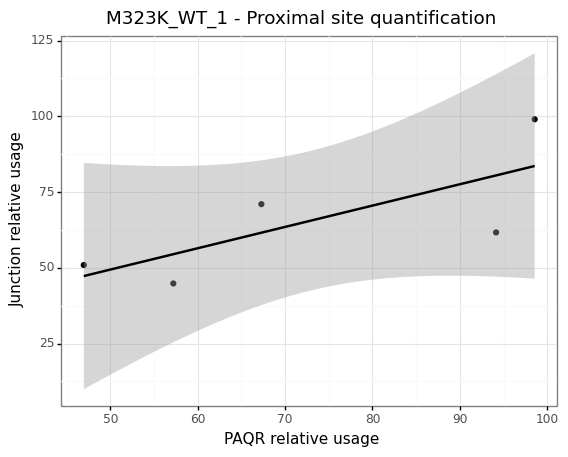

<ggplot: (8786965525224)>

In [205]:
#print(small_paqr_rel_usages.info())
#print(wt_1_rel_usage_df.info())

#print(wt_1_rel_usage_df[["site_id", "site_coordinate", "jnc_rel_usage", "n_along_exon", "total_n_on_exon"]])


#Single df with wt_1 and hom_1 added, ready to plot
small_merged = (small_paqr_rel_usages.merge(wt_1_rel_usage_df[["site_id", 
                                                               "site_coordinate", 
                                                               "jnc_rel_usage", 
                                                               "n_along_exon", 
                                                               "total_n_on_exon"]],
                                  on="site_id",
                                  suffixes=[".paqr", ".jnc_M323K_WT_1"])
               .rename({'jnc_rel_usage' : 'jnc_rel_usage_M323K_WT_1'}, axis=1))


small_merged = (small_merged.merge(hom_1_rel_usage_df[["site_id", "jnc_rel_usage"]],
                                 on = "site_id",
                                 suffixes=[".paqr", ".jnc_M323K_HOM_1"])
                .rename({'jnc_rel_usage' : 'jnc_rel_usage_M323K_HOM_1'}, axis=1))


small_merged = small_merged.loc[:,~small_merged.columns.duplicated()]

#print(small_merged)




small_merged_filtered = small_merged[["site_id", 
                             "gene_id",
                             "strand",
                             "n_along_exon.paqr",
                             "total_n_on_exon",
                             "site_coordinate",                             
                             "M323K_WT_1",
                             "M323K_HOM_1",
                             "jnc_rel_usage_M323K_WT_1",
                             "jnc_rel_usage_M323K_HOM_1"]]

#print(small_merged_filtered)


## Plot proximal sites relative usage only...
from plotnine import *



small_merged_filtered_prox = small_merged_filtered[small_merged_filtered["n_along_exon.paqr"] == 1]
print(small_merged_filtered_prox)

corr_test = small_merged_filtered["M323K_WT_1"].corr(small_merged_filtered["jnc_rel_usage_M323K_WT_1"])
print(corr_test)

corr_test_df = small_merged_filtered[["M323K_WT_1", "M323K_HOM_1", "jnc_rel_usage_M323K_WT_1", "jnc_rel_usage_M323K_HOM_1"]].corr()
print(corr_test_df)

(ggplot(small_merged_filtered_prox, aes(x = "M323K_WT_1", y = "jnc_rel_usage_M323K_WT_1")) +
           geom_point() +
 labs(title = "M323K_WT_1 - Proximal site quantification",
      x = "PAQR relative usage",
     y = "Junction relative usage") +
 stat_smooth(method = "lm") +
 theme_bw()
)




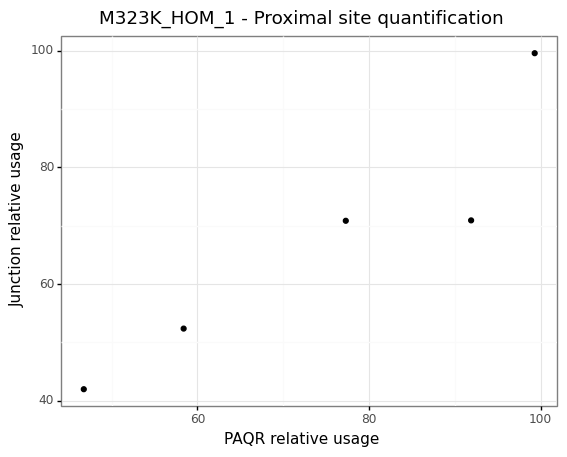

<ggplot: (8786965818772)>

In [198]:
(ggplot(small_merged_filtered_prox, aes(x = "M323K_HOM_1", y = "jnc_rel_usage_M323K_HOM_1")) +
           geom_point() +
 labs(title = "M323K_HOM_1 - Proximal site quantification",
      x = "PAQR relative usage",
     y = "Junction relative usage") +
 theme_bw()
)



An early look is fairly encouraging, but 5 transcripts is hardly enough to draw a conclusion...

I need to generate relative usages dicts for all 1.5k events/ transcripts

have polya_jnc_coords & splice_jnc_coords dictionaries

1. get_polya_junction_counts_dict
2. get_splice_junction_counts_dict
3. get_polya_relative_usage_dict
4. rel_usage_dict_to_df
    a. coord_from_site_id
    b. strand_from_site_id
    c. add_n_along_exon
    d. get_total_n_along_exon
5. Merge with paqr rel_usages df




In [211]:
def junction_quant_wrapper(polya_coords_dict, splice_coords_dict, bam_paths_dict, overhang = 3):
    '''
    For each bam path, return dicts of polya_jnc_counts, splice_jnc counts, rel_usages
    where each dict is nested as {bam_name: results_dict}
    '''
    
    polya_jnc_counts = {bam_name: get_polya_junction_counts_dict(bam_path, polya_coords_dict, overhang)
                        for bam_name, bam_path in bam_paths_dict.items()}
    
    splice_jnc_counts = {bam_name: get_splice_junction_counts_dict(bam_path, splice_coords_dict, overhang)
                         for bam_name, bam_path in bam_paths_dict.items()}
    
    rel_usages_dict = {bam_name: get_polya_relative_usage_dict(polya_jnc_counts_dict = polya_jnc_counts.get(bam_name),
                                                               splice_jnc_counts_dict = splice_jnc_counts.get(bam_name),
                                                              )
                       for bam_name in bam_paths_dict.keys()}
    
    
    return polya_jnc_counts, splice_jnc_counts, rel_usages_dict
    
    
bams_dict = {'M323K_WT_1': m323k_wt_1_bam_path,
            'M323K_HOM_1': m323k_hom_1_bam_path}

all_polya_jnc_dict, all_splice_jnc_dict, all_rel_usages_dict = junction_quant_wrapper(polya_jnc_coords,
                                                                                     splice_jnc_coords,
                                                                                     bams_dict)

print(all_rel_usages_dict)




{'M323K_WT_1': {'ENSMUST00000000608': {'chr11:+:55110898:TE': 99.01639344262296, 'chr11:+:55113026:TE': 0.9836065573770493}, 'ENSMUST00000000844': {'chr2:+:181515384:TE': 50.92592592592593, 'chr2:+:181515774:TE': 25.462962962962965, 'chr2:+:181516756:TE': 23.61111111111111}, 'ENSMUST00000000896': {'chr2:-:154587124:TE': 44.827586206896555, 'chr2:-:154585759:TE': 55.172413793103445}, 'ENSMUST00000000985': {'chr14:+:54368610:TE': 61.67664670658682, 'chr14:+:54369669:TE': 38.32335329341318}, 'ENSMUST00000001079': {'chr3:-:129983184:TE': 71.00591715976331, 'chr3:-:129982765:TE': 28.994082840236686}, 'ENSMUST00000001166': {'chr1:+:36527215:TE': 30.434782608695656, 'chr1:+:36528234:TE': 69.56521739130434}, 'ENSMUST00000001240': {'chr10:-:78271543:TE': 47.837150127226465, 'chr10:-:78269169:TE': 52.16284987277354}, 'ENSMUST00000001419': {'chr18:+:36798349:TE': 28.57142857142857, 'chr18:+:36799658:TE': 71.42857142857143}, 'ENSMUST00000001566': {'chr17:-:35834807:TE': 91.81905678537055, 'chr17:-

**I seem to have a considerable minority of transcripts that have -ve relative usage values**

**In absence of working out what is happening here for now, let's just remove these transcripts** (let's look later for sure though...)

In [216]:

negative_rel_use_dict = {bam_name : {transcript: rel_use_dict 
                                      for transcript, rel_use_dict in master_rel_use_dict.items() 
                                      if any([True for rel_use in rel_use_dict.values() if rel_use < 0])
                                     } 
                          for bam_name, master_rel_use_dict in all_rel_usages_dict.items()}


positive_rel_use_dict = {bam_name : {transcript: rel_use_dict 
                                      for transcript, rel_use_dict in master_rel_use_dict.items() 
                                      if not any([True for rel_use in rel_use_dict.values() if rel_use < 0])
                                     } 
                          for bam_name, master_rel_use_dict in all_rel_usages_dict.items()}



for bam_name, rel_use_dict in all_rel_usages_dict.items():
    print("Sample: {}".format(bam_name))
    print("Number of transcripts with relative usage quantified: {}".format(len(rel_use_dict)))

for bam_name, rel_use_dict in positive_rel_use_dict.items():
    print("Sample: {}".format(bam_name))
    print("Number of transcripts with all +ve relative usage values: {}".format(len(rel_use_dict)))

for bam_name, rel_use_dict in negative_rel_use_dict.items():
    print("Sample: {}".format(bam_name))
    print("Number of transcripts with a -ve relative usage value: {}".format(len(rel_use_dict)))

#print(negative_rel_use_dict)


def junction_dict_to_df_wrapper(rel_usages_dict, paqr_rel_usages_df):
    '''
    4. rel_usage_dict_to_df
    a. coord_from_site_id
    b. strand_from_site_id
    c. add_n_along_exon
    d. get_total_n_along_exon
    5. Merge with paqr rel_usages df
    '''
    
    rel_usages_df_dict = {bam_name: rel_usage_dict_to_df(rel_use_dict) 
     for bam_name, rel_use_dict in rel_usages_dict.items()}
    
    processed_rel_usages_df_dict = {bam_name: coord_from_site_id(rel_use_dict) 
     for bam_name, rel_use_dict in rel_usages_df_dict.items()}
    
    processed_rel_usages_df_dict = {bam_name: strand_from_site_id(rel_use_dict) 
     for bam_name, rel_use_dict in processed_rel_usages_df_dict.items()}
    
    
    

Sample: M323K_WT_1
Number of transcripts with relative usage quantified: 1696
Sample: M323K_HOM_1
Number of transcripts with relative usage quantified: 1696
Sample: M323K_WT_1
Number of transcripts with all +ve relative usage values: 1536
Sample: M323K_HOM_1
Number of transcripts with all +ve relative usage values: 1553
Sample: M323K_WT_1
Number of transcripts with a -ve relative usage value: 160
Sample: M323K_HOM_1
Number of transcripts with a -ve relative usage value: 143
{'M323K_WT_1': {'ENSMUST00000001920': {'chr2:+:31971839:TE': -15.151515151515152, 'chr2:+:31973441:TE': 115.15151515151516}, 'ENSMUST00000001950': {'chr7:-:141883039:TE': -766.6666666666667, 'chr7:-:141881584:TE': 866.6666666666666}, 'ENSMUST00000003513': {'chr7:+:45077875:TE': -623.0769230769231, 'chr7:+:45078200:TE': 723.0769230769231}, 'ENSMUST00000004051': {'chr11:-:90338566:TE': -138.0, 'chr11:-:90336536:TE': 238.0}, 'ENSMUST00000004054': {'chr16:+:36035515:TE': -10.037174721189592, 'chr16:+:36037113:TE': 110.0

In [ ]:
## Let's get some pandas dfs
